# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


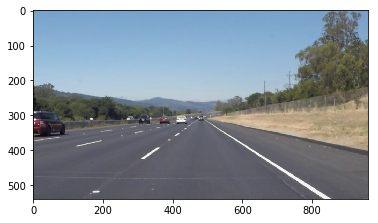

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [45]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    r_num=r_x1=r_x2=r_y1=r_y2=0
    l_num=l_x1=l_x2=l_y1=l_y2=0
    
    for line in lines:
            for x1,y1,x2,y2 in line:
                if (y2-y1)/(x2-x1) > 0:
                    # left lane
                    l_num = l_num + 1
                    l_x1 = l_x1 + x1
                    l_x2 = l_x2 + x2
                    l_y1 = l_y1 + y1
                    l_y2 = l_y2 + y2
                else:
                    # right lane
                    r_num = r_num + 1
                    r_x1 = r_x1 + x1
                    r_x2 = r_x2 + x2
                    r_y1 = r_y1 + y1
                    r_y2 = r_y2 + y2    
    
    y_half = img.shape[1]/3
    
    if l_num != 0:
        l_x1 = l_x1 / l_num
        l_x2 = l_x2 / l_num
        l_y1 = l_y1 / l_num
        l_y2 = l_y2 / l_num
        l_a = (l_y2-l_y1)/(l_x2-l_x1+0.00000001)
        l_x_top = (y_half-l_y1)/(l_a+0.00000001) + l_x1
        l_x_btm = (img.shape[1]-l_y2)/(l_a+0.00000001) + l_x2

        cv2.line(img, (int(l_x_top), int(y_half)), (int(l_x_btm), img.shape[1]), color, thickness)
    #     cv2.line(img, (l_x1, l_y1), (l_x2, l_y2), color, thickness)
    
    if r_num != 0:
        r_x1 = r_x1 / r_num
        r_x2 = r_x2 / r_num
        r_y1 = r_y1 / r_num
        r_y2 = r_y2 / r_num
        r_a = (r_y2-r_y1)/(r_x2-r_x1+0.00000001)
        r_x_top = (y_half-r_y1)/(r_a+0.000000001) + r_x1
        r_x_btm = (img.shape[1]-r_y2)/(r_a+0.00000001) + r_x2

        print('r_top:', r_x_top, 'r_btm:', r_x_btm)

        cv2.line(img, (int(r_x_btm), img.shape[1]), (int(r_x_top), int(y_half)), color, thickness)
    #     cv2.line(img, (int(r_x_top), 0), (int(r_x_btm), img.shape[1]), color, thickness)

#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

r_top: 465.749636337 r_btm: -361.499283195
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
r_top: 462.04119871 r_btm: -429.644207546
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
r_top: 466.753138396 r_btm: -408.895409109
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
r_top: 463.696366092 r_btm: -399.140691587
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
r_top: 457.614596963 r_btm: -439.69655576
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
r_top: 469.870873103 r_btm: -365.292124459
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


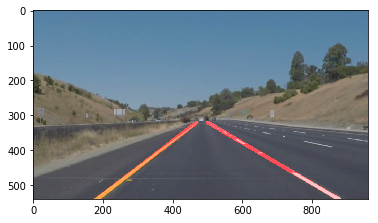

In [46]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def find_lane(image):
    # Read in and grayscale the image
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(150,imshape[0]),(450, 300), (500, 300), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 60     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 80    # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold,
                                min_line_length, max_line_gap)

#     plt.imshow(masked_edges)
    
    return weighted_img(line_image, image)

# write images to test_images_output
image_list = os.listdir("test_images/")

for file in image_list:
    #reading in an image
    image = mpimg.imread("test_images/" + file)
#     image = mpimg.imread("test_images/" + "solidYellowCurve2.jpg")

    result_image = find_lane(image)

    #printing out some stats and plotting
    print('This image is:', type(result_image), 'with dimensions:', result_image.shape)
    plt.imshow(result_image)

    rgb_img = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    cv2.imwrite("test_images_output/" + file, rgb_img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = find_lane(image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [47]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

r_top: 454.745502579 r_btm: -417.458407625
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4








  0%|          | 0/222 [00:00<?, ?it/s]





  2%|▏         | 5/222 [00:00<00:04, 43.54it/s]

r_top: 454.745502579 r_btm: -417.458407625
r_top: 455.567600879 r_btm: -407.380035945
r_top: 460.634164533 r_btm: -432.738281071
r_top: 458.62500031 r_btm: -421.375010682
r_top: 458.215415234 r_btm: -427.160091715
r_top: 458.000000199 r_btm: -438.000012992
r_top: 458.873239681 r_btm: -430.516444717
r_top: 457.838565212 r_btm: -443.327367405








  4%|▍         | 9/222 [00:00<00:05, 40.52it/s]





  6%|▋         | 14/222 [00:00<00:04, 42.43it/s]

r_top: 458.451219723 r_btm: -439.109769132
r_top: 459.490718558 r_btm: -423.802272468
r_top: 463.040057512 r_btm: -442.024333619
r_top: 463.91905477 r_btm: -433.731388222
r_top: 460.373792656 r_btm: -429.288056118
r_top: 461.114567903 r_btm: -427.50456425
r_top: 454.780781066 r_btm: -411.045057081
r_top: 458.457711815 r_btm: -439.452746856
r_top: 455.000000205 r_btm: -425.000012457








  8%|▊         | 18/222 [00:00<00:04, 41.53it/s]





 11%|█         | 24/222 [00:00<00:04, 44.34it/s]

r_top: 455.005474695 r_btm: -444.264611589
r_top: 457.368167485 r_btm: -439.866572431
r_top: 460.091847451 r_btm: -429.567608196
r_top: 461.966861802 r_btm: -432.536075218
r_top: 462.268656956 r_btm: -430.865684453
r_top: 461.709629915 r_btm: -452.779272669
r_top: 461.367048677 r_btm: -453.44212542
r_top: 457.851422521 r_btm: -436.040805648
r_top: 458.771798744 r_btm: -434.089249436
r_top: 459.1372954 r_btm: -427.420093059








 13%|█▎        | 28/222 [00:00<00:04, 41.78it/s]





 14%|█▍        | 32/222 [00:00<00:04, 41.06it/s]

r_top: 460.465174398 r_btm: -411.176627975
r_top: 458.967213324 r_btm: -422.344274788
r_top: 458.72173933 r_btm: -440.060882599
r_top: 457.616161899 r_btm: -445.587314702
r_top: 458.445701544 r_btm: -439.29186825
r_top: 458.352697304 r_btm: -439.240676917
r_top: 458.509186581 r_btm: -423.38058984
r_top: 458.933635266 r_btm: -443.147826009
r_top: 459.971128841 r_btm: -440.396338454








 17%|█▋        | 37/222 [00:00<00:04, 42.31it/s]





 19%|█▉        | 42/222 [00:00<00:04, 43.29it/s]

r_top: 458.736783903 r_btm: -433.416818483
r_top: 457.845757254 r_btm: -406.741411126
r_top: 454.16071462 r_btm: -428.12501103
r_top: 463.333333624 r_btm: -451.629641857
r_top: 455.360000224 r_btm: -461.120013587
r_top: 457.005618123 r_btm: -427.488776667
r_top: 458.793814613 r_btm: -491.309292942








 21%|██        | 47/222 [00:01<00:05, 30.64it/s]

r_top: 456.19811339 r_btm: -443.424541365
r_top: 457.439914367 r_btm: -440.757523736
r_top: 454.942029203 r_btm: -440.710157829
r_top: 453.431034737 r_btm: -429.327598733
r_top: 452.87925726 r_btm: -426.873077357








 23%|██▎       | 51/222 [00:01<00:05, 30.55it/s]





 25%|██▍       | 55/222 [00:01<00:05, 31.09it/s]

r_top: 455.300680606 r_btm: -431.991849355
r_top: 465.117704683 r_btm: -460.018494707
r_top: 460.687764022 r_btm: -468.932502281
r_top: 460.925926219 r_btm: -463.518531034
r_top: 455.692029204 r_btm: -460.829723734
r_top: 456.269516985 r_btm: -476.369902498
r_top: 454.735772583 r_btm: -455.833346666
r_top: 457.179245483 r_btm: -475.650957394








 27%|██▋       | 59/222 [00:01<00:05, 31.17it/s]





 28%|██▊       | 63/222 [00:01<00:05, 31.31it/s]

r_top: 458.376595971 r_btm: -475.75107785
r_top: 459.540892448 r_btm: -473.098527044
r_top: 458.158730453 r_btm: -479.346952853
r_top: 460.52083366 r_btm: -466.145846338
r_top: 461.646948681 r_btm: -477.620670546
r_top: 462.166667021 r_btm: -477.622820183
r_top: 464.246862306 r_btm: -459.602521927








 30%|███       | 67/222 [00:01<00:04, 32.82it/s]

r_top: 466.23529447 r_btm: -474.94118872
r_top: 459.512145989 r_btm: -491.419042931
r_top: 458.844203168 r_btm: -489.561608722
r_top: 457.101010286 r_btm: -499.666681484
r_top: 454.191387755 r_btm: -479.779918361
r_top: 458.002118878 r_btm: -510.133489723








 32%|███▏      | 71/222 [00:02<00:05, 27.75it/s]

r_top: 460.70992393 r_btm: -509.061083883
r_top: 455.793201356 r_btm: -472.478767397
r_top: 455.135951976 r_btm: -459.425995309
r_top: 455.152103866 r_btm: -472.744350338








 33%|███▎      | 74/222 [00:02<00:06, 24.41it/s]





 35%|███▍      | 77/222 [00:02<00:05, 25.61it/s]

r_top: 455.512755475 r_btm: -455.507666397
r_top: 455.302111184 r_btm: -458.25990783
r_top: 454.903587653 r_btm: -492.181628862
r_top: 454.666666862 r_btm: -508.565671503
r_top: 455.345454766 r_btm: -510.472742295
r_top: 454.930894557 r_btm: -507.670746623
r_top: 455.789473895 r_btm: -521.052646959








 36%|███▋      | 81/222 [00:02<00:05, 27.25it/s]





 38%|███▊      | 84/222 [00:02<00:05, 25.53it/s]

r_top: 455.323788777 r_btm: -511.724684639
r_top: 454.237197012 r_btm: -496.274947137
r_top: 455.408046245 r_btm: -508.270129866
r_top: 456.686408803 r_btm: -502.584676923








 39%|███▉      | 87/222 [00:02<00:05, 24.13it/s]

r_top: 454.400163259 r_btm: -468.827234556
r_top: 455.173077247 r_btm: -474.531079045
r_top: 457.027778035 r_btm: -474.527791757
r_top: 457.277777997 r_btm: -511.611126206
r_top: 457.059671025 r_btm: -509.524706432








 41%|████      | 90/222 [00:02<00:05, 22.60it/s]





 42%|████▏     | 93/222 [00:03<00:06, 21.24it/s]

r_top: 458.025854346 r_btm: -501.087734146
r_top: 459.540833604 r_btm: -498.859181434
r_top: 459.633177784 r_btm: -509.338800174
r_top: 458.342967483 r_btm: -514.605024852








 43%|████▎     | 96/222 [00:03<00:06, 19.66it/s]

r_top: 459.82283491 r_btm: -507.736235495
r_top: 459.7898897 r_btm: -501.726713168
r_top: 459.397849774 r_btm: -498.537649237
r_top: 458.009804272 r_btm: -474.203095219
r_top: 461.337079008 r_btm: -487.87641905








 45%|████▍     | 99/222 [00:03<00:05, 20.73it/s]





 46%|████▌     | 102/222 [00:03<00:05, 21.20it/s]

r_top: 459.931818533 r_btm: -485.522741692
r_top: 458.850467523 r_btm: -569.934596555
r_top: 457.527918975 r_btm: -510.593923741
r_top: 460.596591076 r_btm: -495.7670602








 47%|████▋     | 105/222 [00:03<00:06, 18.96it/s]

r_top: 466.127659787 r_btm: -568.765974669
r_top: 464.000000209 r_btm: -496.000014713
r_top: 466.340708192 r_btm: -507.818599386








 48%|████▊     | 107/222 [00:03<00:07, 15.53it/s]

r_top: 459.396887406 r_btm: -476.945539417
r_top: 460.462158074 r_btm: -470.16587546
r_top: 459.495622024 r_btm: -489.856406581
r_top: 460.785626122 r_btm: -464.716246751








 50%|████▉     | 110/222 [00:03<00:06, 17.11it/s]





 51%|█████     | 113/222 [00:04<00:05, 19.38it/s]

r_top: 459.403773924 r_btm: -455.916994574
r_top: 464.329114379 r_btm: -448.413515521
r_top: 461.512552486 r_btm: -430.202940853
r_top: 462.125628338 r_btm: -502.698507448
r_top: 462.636986521 r_btm: -501.746590309
r_top: 461.306122693 r_btm: -505.22450488








 52%|█████▏    | 116/222 [00:04<00:04, 21.58it/s]





 54%|█████▎    | 119/222 [00:04<00:04, 23.17it/s]

r_top: 460.621951421 r_btm: -504.060990612
r_top: 460.931818406 r_btm: -501.977287614
r_top: 460.697944848 r_btm: -510.454885609
r_top: 460.666666945 r_btm: -512.133348554
r_top: 460.736760426 r_btm: -475.338020103








 55%|█████▍    | 122/222 [00:04<00:04, 22.73it/s]

r_top: 462.897747263 r_btm: -468.818038063
r_top: 465.004474681 r_btm: -471.371377623
r_top: 462.885088077 r_btm: -448.272819165
r_top: 463.731829866 r_btm: -464.989987576
r_top: 462.987234265 r_btm: -468.417035237








 56%|█████▋    | 125/222 [00:04<00:04, 20.91it/s]





 58%|█████▊    | 128/222 [00:04<00:04, 18.82it/s]

r_top: 462.639535135 r_btm: -470.073657373
r_top: 464.397849653 r_btm: -519.688187623
r_top: 464.824257619 r_btm: -469.829221944
r_top: 464.867713219 r_btm: -467.867726965
r_top: 464.403226042 r_btm: -454.306465142








 59%|█████▉    | 131/222 [00:04<00:04, 20.18it/s]





 60%|██████    | 134/222 [00:05<00:04, 19.73it/s]

r_top: 465.839080732 r_btm: -459.481130206
r_top: 466.989648347 r_btm: -457.896494051
r_top: 465.699346767 r_btm: -449.238278418
r_top: 461.854057992 r_btm: -434.481033377








 62%|██████▏   | 137/222 [00:05<00:04, 18.90it/s]

r_top: 461.638535426 r_btm: -450.463389226
r_top: 462.204142327 r_btm: -429.63018868
r_top: 462.564626188 r_btm: -443.01361664
r_top: 459.528846382 r_btm: -438.932705336
r_top: 460.902482533 r_btm: -440.09043851








 63%|██████▎   | 140/222 [00:05<00:04, 20.23it/s]





 64%|██████▍   | 143/222 [00:05<00:03, 20.17it/s]

r_top: 463.03694599 r_btm: -435.48523467
r_top: 464.351351551 r_btm: -437.99100407
r_top: 465.59475829 r_btm: -435.05041624
r_top: 465.766904169 r_btm: -431.599657062








 66%|██████▌   | 146/222 [00:05<00:04, 18.49it/s]

r_top: 464.839941536 r_btm: -434.54333168
r_top: 463.572727594 r_btm: -407.990921274
r_top: 463.341061713 r_btm: -428.900064235








 67%|██████▋   | 148/222 [00:05<00:04, 15.76it/s]





 68%|██████▊   | 151/222 [00:06<00:03, 17.83it/s]

r_top: 464.300091404 r_btm: -430.768165684
r_top: 458.601835241 r_btm: -412.346187012
r_top: 468.12500035 r_btm: -442.644241782
r_top: 463.067193901 r_btm: -419.778668604
r_top: 466.000000264 r_btm: -430.000012932








 69%|██████▉   | 153/222 [00:06<00:03, 18.31it/s]





 70%|██████▉   | 155/222 [00:06<00:03, 17.44it/s]

r_top: 465.220720892 r_btm: -429.914427301
r_top: 462.915094526 r_btm: -406.518879982
r_top: 463.555102254 r_btm: -416.771441008
r_top: 464.27464813 r_btm: -419.105646404








 71%|███████   | 157/222 [00:06<00:03, 16.48it/s]





 72%|███████▏  | 159/222 [00:06<00:03, 17.33it/s]

r_top: 463.565678239 r_btm: -408.298741011
r_top: 463.477857459 r_btm: -416.065012366
r_top: 459.633459027 r_btm: -401.719935766
r_top: 457.509971922 r_btm: -406.763543335








 73%|███████▎  | 161/222 [00:06<00:03, 16.15it/s]

r_top: 462.166967863 r_btm: -404.259035061
r_top: 461.484536381 r_btm: -383.051556115
r_top: 463.160000206 r_btm: -381.640011413
r_top: 465.790657695 r_btm: -417.807971008








 74%|███████▍  | 164/222 [00:06<00:03, 17.18it/s]





 75%|███████▍  | 166/222 [00:06<00:03, 16.37it/s]

r_top: 465.150000153 r_btm: -366.850011127
r_top: 465.286666838 r_btm: -370.980011276
r_top: 467.566108208 r_btm: -385.171333778
r_top: 469.834694108 r_btm: -384.36939919








 76%|███████▌  | 168/222 [00:07<00:03, 16.50it/s]





 77%|███████▋  | 170/222 [00:07<00:03, 17.26it/s]

r_top: 467.928889134 r_btm: -359.804455349
r_top: 466.627254108 r_btm: -367.769428607
r_top: 468.743980077 r_btm: -363.49937667
r_top: 464.252146288 r_btm: -355.662027962








 77%|███████▋  | 172/222 [00:07<00:02, 16.79it/s]





 78%|███████▊  | 174/222 [00:07<00:02, 16.74it/s]

r_top: 462.451833207 r_btm: -355.962499124
r_top: 466.323363612 r_btm: -378.823374864
r_top: 464.00531936 r_btm: -341.668450119








 79%|███████▉  | 176/222 [00:07<00:02, 17.38it/s]





 81%|████████  | 179/222 [00:07<00:02, 18.39it/s]

r_top: 467.603960563 r_btm: -413.188131321
r_top: 468.763393028 r_btm: -368.379475585
r_top: 464.588495754 r_btm: -339.659302286
r_top: 465.276190684 r_btm: -354.256287721








 82%|████████▏ | 181/222 [00:07<00:02, 17.57it/s]







r_top: 462.306228597 r_btm: -330.496549735
r_top: 464.040160886 r_btm: -330.176716933
r_top: 462.314607062 r_btm: -338.969512617
r_top: 465.650771745 r_btm: -342.203375689
r_top: 461.691824269 r_btm: -342.534599306


 83%|████████▎ | 184/222 [00:07<00:01, 19.05it/s]





 84%|████████▍ | 186/222 [00:08<00:02, 17.26it/s]

r_top: 466.602041097 r_btm: -358.43198213
r_top: 461.306722868 r_btm: -334.659673959
r_top: 459.43442645 r_btm: -364.172141716








 85%|████████▍ | 188/222 [00:08<00:02, 14.28it/s]





 86%|████████▌ | 190/222 [00:08<00:02, 13.24it/s]

r_top: 463.866795564 r_btm: -361.461400921
r_top: 458.864865017 r_btm: -345.459469943
r_top: 453.804347988 r_btm: -334.601459095








 86%|████████▋ | 192/222 [00:08<00:02, 14.73it/s]

r_top: 458.95719864 r_btm: -350.381333427
r_top: 459.886525042 r_btm: -329.900719063
r_top: 465.08482786 r_btm: -346.170355412
r_top: 468.58989458 r_btm: -353.407766397
r_top: 467.241604387 r_btm: -363.314797837








 88%|████████▊ | 195/222 [00:08<00:01, 15.99it/s]





 89%|████████▉ | 198/222 [00:08<00:01, 17.87it/s]





 90%|█████████ | 200/222 [00:08<00:01, 17.29it/s]

r_top: 467.362256331 r_btm: -351.726691852
r_top: 470.795045393 r_btm: -356.592350916
r_top: 468.919540376 r_btm: -443.264381279
r_top: 461.147887513 r_btm: -300.542262845
r_top: 468.307692477 r_btm: -417.846166563








 91%|█████████ | 202/222 [00:09<00:01, 17.51it/s]

r_top: 460.669811473 r_btm: -330.273594925
r_top: 463.07843154 r_btm: -340.058833947
r_top: 464.065461013 r_btm: -362.807935143








 92%|█████████▏| 204/222 [00:09<00:01, 15.61it/s]





 93%|█████████▎| 206/222 [00:09<00:00, 16.33it/s]

r_top: 467.039159755 r_btm: -374.680048941
r_top: 466.915459228 r_btm: -372.504841554
r_top: 468.79180922 r_btm: -361.242330758
r_top: 464.282776716 r_btm: -351.758364806
r_top: 456.927383009 r_btm: -331.211809627








 94%|█████████▍| 209/222 [00:09<00:00, 17.65it/s]





 95%|█████████▌| 212/222 [00:09<00:00, 19.36it/s]

r_top: 456.842832762 r_btm: -325.747849067
r_top: 461.500000189 r_btm: -302.944453878
r_top: 466.886792706 r_btm: -354.245293776
r_top: 462.90410975 r_btm: -355.360741385








 97%|█████████▋| 215/222 [00:09<00:00, 19.58it/s]

r_top: 462.360215225 r_btm: -330.758074674
r_top: 464.880000207 r_btm: -354.320010804
r_top: 464.086092942 r_btm: -353.927163105
r_top: 462.063158168 r_btm: -339.62106234








 98%|█████████▊| 218/222 [00:09<00:00, 18.99it/s]





 99%|█████████▉| 220/222 [00:09<00:00, 18.58it/s]





100%|█████████▉| 221/222 [00:10<00:00, 22.02it/s]

r_top: 459.79874246 r_btm: -335.169820593
r_top: 463.798507796 r_btm: -364.062199921
r_top: 462.619047981 r_btm: -360.238105066
r_top: 462.89112931 r_btm: -352.592751087
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.41 s, sys: 3.89 s, total: 10.3 s
Wall time: 11 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [49]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

r_top: 468.07894768 r_btm: -571.141342818
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4








  0%|          | 0/682 [00:00<?, ?it/s]





  1%|          | 4/682 [00:00<00:17, 39.19it/s]

r_top: 468.07894768 r_btm: -571.141342818
r_top: 469.089015459 r_btm: -572.123123553
r_top: 470.429980597 r_btm: -572.252482767
r_top: 466.095238434 r_btm: -521.333348928
r_top: 469.313090783 r_btm: -526.96222921
r_top: 470.328740513 r_btm: -532.505921697
r_top: 469.545627703 r_btm: -519.65590885








  1%|▏         | 9/682 [00:00<00:16, 41.38it/s]

r_top: 470.973178221 r_btm: -520.746953814
r_top: 464.263423726 r_btm: -488.241094866








  2%|▏         | 14/682 [00:00<00:15, 43.25it/s]

r_top: 466.512853006 r_btm: -497.499700681
r_top: 465.979177722 r_btm: -502.247058607
r_top: 464.13354066 r_btm: -503.154258962
r_top: 464.647606736 r_btm: -485.139641485
r_top: 464.912242219 r_btm: -481.872432228
r_top: 463.769231088 r_btm: -462.664349027
r_top: 464.369956212 r_btm: -464.05420991
r_top: 463.674768898 r_btm: -463.732652078








  3%|▎         | 19/682 [00:00<00:14, 44.97it/s]

r_top: 464.558767881 r_btm: -462.506049166
r_top: 464.617738777 r_btm: -460.615090715








  4%|▎         | 24/682 [00:00<00:14, 46.13it/s]

r_top: 463.15082685 r_btm: -462.46902155
r_top: 461.89397355 r_btm: -460.963182115
r_top: 461.107321499 r_btm: -463.21881496
r_top: 462.096370051 r_btm: -459.250177778
r_top: 459.828571795 r_btm: -472.74287044
r_top: 463.169014489 r_btm: -465.28170308
r_top: 458.892857467 r_btm: -431.332718644
r_top: 461.184198549 r_btm: -441.817216333
r_top: 458.857607427 r_btm: -426.932655671








  4%|▍         | 30/682 [00:00<00:13, 48.00it/s]

r_top: 456.811586391 r_btm: -422.558504282
r_top: 457.362156054 r_btm: -417.943245126








  5%|▌         | 35/682 [00:00<00:13, 46.79it/s]

r_top: 458.04135184 r_btm: -427.889068051
r_top: 453.703887225 r_btm: -419.228986473
r_top: 454.01006317 r_btm: -411.398753557
r_top: 453.10454572 r_btm: -395.380314105
r_top: 453.497632421 r_btm: -405.365788464
r_top: 453.784871784 r_btm: -391.727149155
r_top: 453.199315992 r_btm: -409.07614405
r_top: 454.642891922 r_btm: -414.36916808








  6%|▌         | 40/682 [00:00<00:13, 47.44it/s]

r_top: 453.557479597 r_btm: -410.708460131
r_top: 452.432254502 r_btm: -421.620515234








  7%|▋         | 45/682 [00:00<00:13, 45.74it/s]

r_top: 452.704888047 r_btm: -417.255493626
r_top: 453.042605482 r_btm: -418.816293732
r_top: 450.53823668 r_btm: -410.054530219
r_top: 453.846433253 r_btm: -425.28296214
r_top: 453.685555887 r_btm: -412.447788665
r_top: 452.905932189 r_btm: -412.32648247
r_top: 454.514681879 r_btm: -424.49277415








  7%|▋         | 50/682 [00:01<00:20, 31.48it/s]





  8%|▊         | 54/682 [00:01<00:19, 32.08it/s]

r_top: 452.391403035 r_btm: -407.69910652
r_top: 451.724081974 r_btm: -412.928990705
r_top: 452.026245322 r_btm: -412.792070743
r_top: 452.112886908 r_btm: -416.340733335
r_top: 452.959296803 r_btm: -419.402524352
r_top: 450.005612823 r_btm: -417.695715987
r_top: 453.764341415 r_btm: -418.421716838








  9%|▊         | 58/682 [00:01<00:20, 29.97it/s]

r_top: 454.491413079 r_btm: -415.979512697
r_top: 451.468772726 r_btm: -416.068927118
r_top: 452.100719751 r_btm: -418.115119829
r_top: 453.536345462 r_btm: -423.854971326
r_top: 453.797565884 r_btm: -418.472108772
r_top: 456.644822603 r_btm: -437.574663973








  9%|▉         | 62/682 [00:01<00:20, 29.80it/s]





 10%|▉         | 66/682 [00:01<00:21, 28.80it/s]

r_top: 455.693741045 r_btm: -439.92475156
r_top: 454.339622952 r_btm: -433.207559375
r_top: 453.663324148 r_btm: -439.402591139
r_top: 453.074221683 r_btm: -447.760781419
r_top: 454.2362486 r_btm: -439.416796644
r_top: 454.191837109 r_btm: -440.066679138








 10%|█         | 70/682 [00:01<00:22, 27.65it/s]

r_top: 454.891204077 r_btm: -436.960660138
r_top: 456.297702328 r_btm: -439.524037482
r_top: 458.329687816 r_btm: -457.670325861
r_top: 456.987673681 r_btm: -437.434527079
r_top: 458.294399281 r_btm: -444.875012791
r_top: 455.776367511 r_btm: -436.723644689








 11%|█         | 73/682 [00:02<00:22, 27.62it/s]





 11%|█         | 76/682 [00:02<00:23, 25.29it/s]

r_top: 457.429897588 r_btm: -436.491228124
r_top: 456.539368166 r_btm: -432.656046189
r_top: 457.113945895 r_btm: -437.579944337
r_top: 461.892857521 r_btm: -452.39286989
r_top: 457.583718054 r_btm: -439.458357454








 12%|█▏        | 79/682 [00:02<00:26, 23.12it/s]

r_top: 457.083582391 r_btm: -440.82687855
r_top: 458.267890272 r_btm: -438.403157559
r_top: 457.790098564 r_btm: -443.028244625
r_top: 456.510444209 r_btm: -439.155365441
r_top: 456.34770075 r_btm: 







 12%|█▏        | 82/682 [00:02<00:28, 21.16it/s]





 12%|█▏        | 85/682 [00:02<00:28, 20.59it/s]

-439.315912248
r_top: 454.994917686 r_btm: -441.167738523
r_top: 453.70879154 r_btm: -439.478034521
r_top: 453.335322546 r_btm: -434.87471387








 13%|█▎        | 88/682 [00:02<00:31, 18.58it/s]

r_top: 453.613707472 r_btm: -442.728093986
r_top: 457.467683235 r_btm: -461.556720294
r_top: 458.499304922 r_btm: -468.121014649
r_top: 458.3177169 r_btm: -470.942139327








 13%|█▎        | 90/682 [00:03<00:33, 17.54it/s]





 14%|█▎        | 93/682 [00:03<00:30, 19.44it/s]

r_top: 457.959677752 r_btm: -471.072594371
r_top: 459.456164758 r_btm: -468.10549312
r_top: 462.310258642 r_btm: -467.847574388
r_top: 463.113842574 r_btm: -465.838306043
r_top: 464.57064596 r_btm: -465.417188093
r_top: 466.105063724 r_btm: -455.008873914








 14%|█▍        | 97/682 [00:03<00:28, 20.84it/s]

r_top: 465.169697334 r_btm: -461.42964327
r_top: 464.980203428 r_btm: -461.720317615
r_top: 465.15415512 r_btm: -462.754167366
r_top: 459.402395561 r_btm: -431.615580521
r_top: 460.050836866 r_btm: -435.805031345
r_top: 465.019588035 r_btm: -461.990734432








 15%|█▍        | 101/682 [00:03<00:24, 23.62it/s]





 15%|█▌        | 105/682 [00:03<00:22, 25.96it/s]





 16%|█▌        | 108/682 [00:03<00:21, 26.90it/s]

r_top: 463.265537097 r_btm: -458.768374936
r_top: 462.216026945 r_btm: -467.06020565
r_top: 463.944101929 r_btm: -456.988696098
r_top: 460.089855403 r_btm: -467.446390005
r_top: 461.829384219 r_btm: -463.289113018
r_top: 461.126316106 r_btm: -472.768434893
r_top: 462.826013905 r_btm: -466.903729847








 16%|█▋        | 111/682 [00:03<00:25, 22.31it/s]

r_top: 462.114613528 r_btm: -474.045859357
r_top: 464.380631016 r_btm: -463.907671477
r_top: 463.281669506 r_btm: -456.18183144
r_top: 462.510518128 r_btm: -440.531566072








 17%|█▋        | 114/682 [00:03<00:24, 22.99it/s]





 17%|█▋        | 117/682 [00:04<00:23, 24.28it/s]

r_top: 465.828713254 r_btm: -461.696052766
r_top: 462.43379823 r_btm: -440.702103142
r_top: 464.274787868 r_btm: -453.118993048
r_top: 463.76404742 r_btm: -458.331637946
r_top: 462.488858636 r_btm: -461.857785054
r_top: 464.200311497 r_btm: -461.073914383








 18%|█▊        | 120/682 [00:04<00:23, 24.02it/s]





 18%|█▊        | 123/682 [00:04<00:22, 25.19it/s]

r_top: 459.586585694 r_btm: -446.754890401
r_top: 459.99034587 r_btm: -440.497470971
r_top: 463.496924783 r_btm: -449.824704995
r_top: 462.046751551 r_btm: -428.47624018
r_top: 462.431931068 r_btm: -427.073032448








 18%|█▊        | 126/682 [00:04<00:22, 24.40it/s]

r_top: 460.683688301 r_btm: -439.552731246
r_top: 461.478632866 r_btm: -435.615397468
r_top: 461.869318556 r_btm: -429.039784944
r_top: 464.717447206 r_btm: -440.133629736
r_top: 464.489583733 r_btm: -443.037311134








 19%|█▉        | 129/682 [00:04<00:28, 19.63it/s]

r_top: 465.180925616 r_btm: -445.744309723
r_top: 463.389807562 r_btm: -441.954558036
r_top: 464.011594553 r_btm: -445.746872826
r_top: 463.848784068 r_btm: -453.863260909








 19%|█▉        | 132/682 [00:04<00:27, 20.11it/s]





 20%|█▉        | 135/682 [00:04<00:25, 21.12it/s]

r_top: 465.012963353 r_btm: -453.505568115
r_top: 465.791391108 r_btm: -448.009947009
r_top: 463.88932074 r_btm: -446.401954653
r_top: 465.877592323 r_btm: -438.826991823
r_top: 462.796923423 r_btm: -434.844114911
r_top: 463.916605516 r_btm: -444.521292026








 20%|██        | 138/682 [00:05<00:26, 20.80it/s]





 21%|██        | 141/682 [00:05<00:30, 18.02it/s]

r_top: 463.906423038 r_btm: -443.938894013
r_top: 464.153383817 r_btm: -436.498258019
r_top: 463.248645347 r_btm: -440.382804291








 21%|██        | 143/682 [00:05<00:36, 14.79it/s]

r_top: 463.173426916 r_btm: -434.616796034
r_top: 461.973444307 r_btm: -436.505129951
r_top: 461.268090104 r_btm: -433.43525102








 21%|██▏       | 145/682 [00:05<00:34, 15.77it/s]





 22%|██▏       | 147/682 [00:05<00:33, 16.14it/s]

r_top: 462.18140161 r_btm: -435.449184439
r_top: 460.632857525 r_btm: -437.652869386
r_top: 460.331202401 r_btm: -437.469321739
r_top: 461.893001707 r_btm: -434.79610963








 22%|██▏       | 149/682 [00:05<00:31, 16.87it/s]





 22%|██▏       | 151/682 [00:05<00:34, 15.18it/s]

r_top: 463.821569015 r_btm: -444.727463993
r_top: 462.930055053 r_btm: -435.168318665
r_top: 465.141010904 r_btm: -441.086969617








 22%|██▏       | 153/682 [00:06<00:36, 14.52it/s]





 23%|██▎       | 155/682 [00:06<00:33, 15.62it/s]

r_top: 465.852317016 r_btm: -447.609729854
r_top: 465.576923467 r_btm: -445.192320577
r_top: 468.01373031 r_btm: -451.711683118
r_top: 466.998694839 r_btm: -436.465199663








 23%|██▎       | 158/682 [00:06<00:31, 16.87it/s]

r_top: 470.293601303 r_btm: -429.079059352
r_top: 475.16545209 r_btm: -452.885273546
r_top: 472.634120484 r_btm: -448.910957707
r_top: 472.711688706 r_btm: -449.885727307
r_top: 







 23%|██▎       | 160/682 [00:06<00:30, 17.25it/s]





 24%|██▍       | 162/682 [00:06<00:36, 14.35it/s]

474.4986441 r_btm: -446.731025557
r_top: 470.306407003 r_btm: -428.18942729
r_top: 470.716522079 r_btm: -430.848707857








 24%|██▍       | 164/682 [00:06<00:36, 14.01it/s]

r_top: 476.341377516 r_btm: -439.591711824
r_top: 471.818639361 r_btm: -430.42989414
r_top: 471.263534852 r_btm: -424.095409219
r_top: 469.968021372 r_btm: -426.703026119








 24%|██▍       | 166/682 [00:06<00:36, 14.19it/s]





 25%|██▍       | 169/682 [00:07<00:33, 15.54it/s]

r_top: 471.555604799 r_btm: -427.257594735
r_top: 472.779297287 r_btm: -422.220715415
r_top: 472.909426133 r_btm: -423.645299942
r_top: 473.717066261 r_btm: -423.815881152
r_top: 474.22471947 r_btm: -429.685406021
r_top: 472.781250337 r_btm: -407.218761898
r_top: 







 25%|██▌       | 173/682 [00:07<00:27, 18.64it/s]





 26%|██▌       | 176/682 [00:07<00:24, 20.55it/s]

473.825581747 r_btm: -409.275205887
r_top: 471.835416973 r_btm: -400.016447334
r_top: 468.636591787 r_btm: -399.667513636
r_top: 471.739887459 r_btm: -397.046578053
r_top: 470.950000311 r_btm: -384.322738062
r_top: 472.398389401 r_btm: -374.59046917
r_top: 471.583333717 r_btm:







 26%|██▋       | 180/682 [00:07<00:21, 23.43it/s]





 27%|██▋       | 184/682 [00:07<00:19, 25.39it/s]

 -381.750011523
r_top: 471.60382901 r_btm: -386.007851253
r_top: 470.010669341 r_btm: -372.250011292
r_top: 469.463871292 r_btm: -377.675925342
r_top: 470.410146759 r_btm: -378.121483296
r_top: 468.508964468 r_btm: -376.750010983








 27%|██▋       | 187/682 [00:07<00:19, 25.42it/s]





 28%|██▊       | 190/682 [00:07<00:18, 26.03it/s]

r_top: 471.746565157 r_btm: -388.100775165
r_top: 472.083474426 r_btm: -380.220517472
r_top: 469.380597361 r_btm: -365.485085058
r_top: 471.925722468 r_btm: -368.789556575
r_top: 469.96602792 r_btm: -360.54861443
r_top: 466.182461042 r_btm: -370.676188628
r_top: 468.528325435 r_btm: -362.998779048








 28%|██▊       | 194/682 [00:07<00:16, 28.78it/s]





 29%|██▉       | 198/682 [00:08<00:16, 29.40it/s]

r_top: 466.456166675 r_btm: -350.423487191
r_top: 468.645833644 r_btm: -365.639891413
r_top: 464.339069427 r_btm: -360.710306195
r_top: 465.812281035 r_btm: -367.170186179
r_top: 466.995761608 r_btm: -365.720424132
r_top: 464.419939878 r_btm: -368.933544999
r_top: 468.083704037 r_btm: -381.457048104








 30%|██▉       | 202/682 [00:08<00:16, 29.16it/s]

r_top: 462.553123202 r_btm: -365.797192997
r_top: 462.577585329 r_btm: -371.114883593
r_top: 464.442021 r_btm: -371.011491739
r_top: 463.3819464 r_btm: -368.69309381
r_top: 461.405970503 r_btm: -364.862696538
r_top: 463.514205665 r_btm: -370.016043985








 30%|███       | 206/682 [00:08<00:16, 28.87it/s]





 31%|███       | 210/682 [00:08<00:15, 30.46it/s]

r_top: 465.031884418 r_btm: -380.881169851
r_top: 464.107769746 r_btm: -382.809534663
r_top: 465.531257272 r_btm: -388.039388605
r_top: 468.404128649 r_btm: -394.31850308
r_top: 467.31038685 r_btm: -392.979479866
r_top: 466.435636614 r_btm: -394.078104236
r_top: 463.862281079 r_btm: -404.909660648








 31%|███▏      | 214/682 [00:08<00:15, 29.92it/s]





 32%|███▏      | 218/682 [00:08<00:15, 30.32it/s]

r_top: 465.872727667 r_btm: -396.798439805
r_top: 463.689024787 r_btm: -400.050824207
r_top: 465.687671605 r_btm: -411.024669261
r_top: 463.935766805 r_btm: -409.640887244
r_top: 466.152259738 r_btm: -419.663077067
r_top: 464.875756135 r_btm: -415.027521292
r_top: 464.232123558 r_btm: -417.968109105








 33%|███▎      | 222/682 [00:08<00:15, 29.36it/s]







r_top: 465.101389231 r_btm: -417.565289718
r_top: 465.850847844 r_btm: -418.216961245
r_top: 465.945593427 r_btm: -431.725801333
r_top: 463.896856382 r_btm: -413.323232722
r_top: 460.919351176 r_btm: -417.183032798
r_top: 464.636220195 r_btm: -418.305665983
r_top: 463.994382446 r_btm: -416.904506611


 33%|███▎      | 225/682 [00:08<00:15, 29.45it/s]





 33%|███▎      | 228/682 [00:09<00:15, 29.00it/s]





 34%|███▍      | 231/682 [00:09<00:15, 29.13it/s]

r_top: 464.827329559 r_btm: -421.632310587
r_top: 466.393187745 r_btm: -419.640887518
r_top: 461.37931073 r_btm: -413.4344944
r_top: 464.001415977 r_btm: -416.079486139
r_top: 462.289649284 r_btm: -409.381065362
r_top: 462.768328842 r_btm: -438.111449849








 34%|███▍      | 235/682 [00:09<00:14, 30.60it/s]





 35%|███▌      | 239/682 [00:09<00:14, 31.40it/s]

r_top: 461.857831666 r_btm: -437.740574592
r_top: 462.741734492 r_btm: -433.998162521
r_top: 464.046406723 r_btm: -438.907766186
r_top: 463.919947875 r_btm: -433.08793887
r_top: 462.218182183 r_btm: -434.557588067
r_top: 460.313289164 r_btm: -439.107658638
r_top: 462.650069504 r_btm: -436.713705808
r_top: 461.306393507 r_btm: -434.230410821








 36%|███▌      | 243/682 [00:09<00:13, 31.70it/s]







r_top: 462.940798327 r_btm: -434.871312563
r_top: 461.46729176 r_btm: -437.496337405
r_top: 462.092228015 r_btm: -432.313914941
r_top: 461.277778062 r_btm: -435.691931667
r_top: 463.099700536 r_btm: -452.282621488
r_top: 466.938494565 r_btm: -452.001073686
r_top: 466.38442251 r_btm: -438.942223984
r_top: 466.715923971 r_btm: -447.220395311


 36%|███▌      | 247/682 [00:09<00:13, 32.21it/s]





 37%|███▋      | 251/682 [00:09<00:15, 28.23it/s]

r_top: 465.575866536 r_btm: -445.869786038
r_top: 465.62327577 r_btm: -432.427471137
r_top: 466.15079401 r_btm: -443.394192557
r_top: 465.277114331 r_btm: -440.017016641
r_top: 466.090156975 r_btm: -458.115673408








 37%|███▋      | 254/682 [00:09<00:15, 27.10it/s]





 38%|███▊      | 257/682 [00:10<00:15, 27.85it/s]

r_top: 466.04204949 r_btm: -430.09456949
r_top: 464.251389238 r_btm: -420.193067198
r_top: 465.557573148 r_btm: -434.462066814
r_top: 463.553233787 r_btm: -421.74646305
r_top: 464.951370255 r_btm: -418.336313127
r_top: 462.839756966 r_btm: -422.5152254








 38%|███▊      | 261/682 [00:10<00:14, 29.26it/s]





 39%|███▉      | 265/682 [00:10<00:14, 29.39it/s]

r_top: 462.143388166 r_btm: -415.598080191
r_top: 462.326350953 r_btm: -421.113573505
r_top: 463.297244052 r_btm: -416.614565227
r_top: 464.475399 r_btm: -418.258098547
r_top: 464.387076525 r_btm: -413.923875944
r_top: 465.157471632 r_btm: -422.645496439
r_top: 464.880000358 r_btm: -431.120012226








 39%|███▉      | 268/682 [00:10<00:15, 27.49it/s]





 40%|███▉      | 272/682 [00:10<00:14, 29.01it/s]

r_top: 465.203100501 r_btm: -426.116466886
r_top: 464.795259001 r_btm: -431.756477465
r_top: 464.482417982 r_btm: -435.034078315
r_top: 467.852890601 r_btm: -437.025735507
r_top: 465.951943852 r_btm: -433.364912129
r_top: 466.491556499 r_btm: -430.589276877
r_top: 467.97407212 r_btm: -429.337080244








 40%|████      | 275/682 [00:10<00:14, 28.71it/s]





 41%|████      | 278/682 [00:10<00:14, 28.76it/s]

r_top: 468.960000374 r_btm: -427.040012415
r_top: 468.813507198 r_btm: -430.517360698
r_top: 468.851117033 r_btm: -430.00745682
r_top: 468.653454971 r_btm: -426.182921776
r_top: 467.360000383 r_btm: -428.640012706
r_top: 467.017810166 r_btm: -426.492370102








 41%|████      | 281/682 [00:10<00:15, 26.27it/s]





 42%|████▏     | 285/682 [00:10<00:13, 29.25it/s]

r_top: 466.005405755 r_btm: -429.129742364
r_top: 467.852240629 r_btm: -429.612023611
r_top: 468.878328192 r_btm: -427.403312992
r_top: 470.890944733 r_btm: -421.323296815
r_top: 470.642147511 r_btm: -425.103392396
r_top: 467.803245814 r_btm: -420.797172124
r_top: 466.497395611 r_btm: -416.311223786








 42%|████▏     | 289/682 [00:11<00:12, 30.88it/s]

r_top: 466.233045807 r_btm: -412.69211021
r_top: 464.955284895 r_btm: -409.19106888
r_top: 466.433046083 r_btm: -419.626410143
r_top: 471.166633552 r_btm: -424.190163441
r_top: 469.62574296 r_btm: -408.631694685
r_top: 468.86146633 r_btm: -406.467012814
r_top: 470.562791093 r_btm: -422.460477288
r_top: 467.509996949 r_btm: -423.989498132








 43%|████▎     | 293/682 [00:11<00:12, 31.11it/s]





 44%|████▎     | 297/682 [00:11<00:13, 28.66it/s]

r_top: 468.521163503 r_btm: -434.095973235
r_top: 469.143026386 r_btm: -416.719869998
r_top: 467.421516359 r_btm: -421.244565993
r_top: 470.047333712 r_btm: -429.79267898
r_top: 469.15548062 r_btm: -421.782384916
r_top: 465.99431284 r_btm: -410.820686705








 44%|████▍     | 301/682 [00:11<00:12, 30.31it/s]





 45%|████▍     | 305/682 [00:11<00:12, 30.69it/s]

r_top: 467.073802605 r_btm: -413.00775951
r_top: 467.950279658 r_btm: -407.133531075
r_top: 467.106765676 r_btm: -402.237854553
r_top: 465.901797949 r_btm: -409.304606023
r_top: 463.267954039 r_btm: -407.774529483
r_top: 463.384969696 r_btm: -412.197864968
r_top: 462.075332708 r_btm: -403.86264062








 45%|████▌     | 309/682 [00:11<00:12, 28.82it/s]

r_top: 463.525926258 r_btm: -421.412358135
r_top: 463.347150668 r_btm: -423.699493914
r_top: 461.786530094 r_btm: -420.770560269
r_top: 461.81474691 r_btm: -420.028583353
r_top: 463.802393527 r_btm: -434.823260187








 46%|████▌     | 312/682 [00:11<00:13, 27.07it/s]





 46%|████▋     | 316/682 [00:12<00:12, 28.91it/s]

r_top: 460.076300912 r_btm: -427.784982909
r_top: 461.930424273 r_btm: -435.825199591
r_top: 459.164980888 r_btm: -427.3719964
r_top: 461.526995634 r_btm: -437.627946573
r_top: 463.32635461 r_btm: -429.993698085
r_top: 463.56851454 r_btm: -432.87491632








 47%|████▋     | 319/682 [00:12<00:13, 27.36it/s]





 47%|████▋     | 322/682 [00:12<00:13, 27.16it/s]

r_top: 467.12698447 r_btm: -435.984139035
r_top: 462.0846348 r_btm: -428.293314128
r_top: 461.361277773 r_btm: -423.908195422
r_top: 461.263211687 r_btm: -412.102653852
r_top: 463.230255491 r_btm: -436.502442386
r_top: 462.021758337 r_btm: -427.795486456








 48%|████▊     | 326/682 [00:12<00:12, 29.57it/s]





 48%|████▊     | 330/682 [00:12<00:11, 30.61it/s]

r_top: 463.743151041 r_btm: -426.119874809
r_top: 463.398000352 r_btm: -426.628679282
r_top: 463.384831815 r_btm: -437.546160048
r_top: 463.849338169 r_btm: -435.54140303
r_top: 463.284641979 r_btm: -432.278510995
r_top: 462.762246475 r_btm: -430.714469043
r_top: 462.146264282 r_btm: -428.155814734








 49%|████▉     | 334/682 [00:12<00:12, 28.62it/s]

r_top: 458.853153503 r_btm: -437.838750983
r_top: 459.490712397 r_btm: -463.852954762
r_top: 461.044453814 r_btm: -452.495527101
r_top: 461.427097576 r_btm: -450.423781518
r_top: 466.180436708 r_btm: -458.798117499








 49%|████▉     | 337/682 [00:12<00:12, 26.58it/s]





 50%|████▉     | 340/682 [00:12<00:12, 26.60it/s]

r_top: 464.570556688 r_btm: -464.601777628
r_top: 464.955808488 r_btm: -464.337134939
r_top: 465.62335998 r_btm: -454.901588118
r_top: 465.972973396 r_btm: -457.906213922
r_top: 466.470418064 r_btm: -453.436788432
r_top: 465.841135149 r_btm: -457.522607306








 50%|█████     | 343/682 [00:12<00:12, 26.59it/s]





 51%|█████     | 347/682 [00:13<00:12, 27.91it/s]

r_top: 465.212062652 r_btm: -463.659546789
r_top: 463.200574218 r_btm: -462.366153761
r_top: 465.461347046 r_btm: -465.0124826
r_top: 464.570732046 r_btm: -465.77074544
r_top: 465.819600912 r_btm: -463.418865155
r_top: 467.418239423 r_btm: -456.355359492
r_top: 465.539737396 r_btm: -469.760448442








 51%|█████▏    | 350/682 [00:13<00:12, 27.50it/s]





 52%|█████▏    | 353/682 [00:13<00:11, 27.85it/s]

r_top: 468.890863383 r_btm: -452.124378561
r_top: 469.035613882 r_btm: -459.346593108
r_top: 468.238955251 r_btm: -461.357258035
r_top: 468.18159702 r_btm: -454.962840478
r_top: 467.045775035 r_btm: -460.653769164
r_top: 467.482532639 r_btm: -460.630024916








 52%|█████▏    | 356/682 [00:13<00:12, 26.76it/s]





 53%|█████▎    | 360/682 [00:13<00:11, 29.23it/s]

r_top: 467.651985957 r_btm: -461.156691851
r_top: 467.221053037 r_btm: -460.169778114
r_top: 467.179400146 r_btm: -463.570954701
r_top: 465.040992825 r_btm: -465.617058047
r_top: 466.065772195 r_btm: -463.437597622
r_top: 465.273207151 r_btm: -463.671954295
r_top: 465.952985106 r_btm: -459.054952887








 53%|█████▎    | 364/682 [00:13<00:10, 29.56it/s]

r_top: 463.015553215 r_btm: -446.048858464
r_top: 466.496662634 r_btm: -464.02404549
r_top: 459.61295449 r_btm: -407.116915073
r_top: 460.73820865 r_btm: -418.6917319
r_top: 461.103502859 r_btm: -438.82567177
r_top: 460.918797316 r_btm: -434.118809534








 54%|█████▍    | 368/682 [00:13<00:11, 27.46it/s]





 54%|█████▍    | 371/682 [00:13<00:11, 26.68it/s]

r_top: 462.682151388 r_btm: -440.201156935
r_top: 462.450634824 r_btm: -449.712795738
r_top: 457.150689385 r_btm: -423.951926414
r_top: 461.932769388 r_btm: -444.282479602
r_top: 460.642509458 r_btm: -431.927539448








 55%|█████▍    | 374/682 [00:14<00:11, 26.90it/s]





 55%|█████▌    | 378/682 [00:14<00:10, 28.45it/s]

r_top: 461.521330639 r_btm: -434.625471186
r_top: 459.301463764 r_btm: -425.77171935
r_top: 461.697727682 r_btm: -432.847739276
r_top: 458.935200326 r_btm: -417.60881182
r_top: 457.576260853 r_btm: -434.524592608
r_top: 457.833227895 r_btm: -435.457790249
r_top: 456.224609666 r_btm: -438.77540349








 56%|█████▌    | 381/682 [00:14<00:10, 27.91it/s]





 56%|█████▋    | 385/682 [00:14<00:10, 29.41it/s]

r_top: 454.952572482 r_btm: -440.405031241
r_top: 457.420642524 r_btm: -445.331664486
r_top: 459.884223389 r_btm: -441.278304236
r_top: 456.750070047 r_btm: -441.213680511
r_top: 457.825136935 r_btm: -439.224055638
r_top: 460.162129057 r_btm: -448.352735624
r_top: 458.315234102 r_btm: -447.14480948








 57%|█████▋    | 388/682 [00:14<00:10, 27.98it/s]





 57%|█████▋    | 391/682 [00:14<00:10, 27.77it/s]

r_top: 458.593861552 r_btm: -451.299389744
r_top: 456.924000325 r_btm: -449.316012266
r_top: 460.166322308 r_btm: -472.891298715
r_top: 461.168837131 r_btm: -471.053398939
r_top: 459.334314065 r_btm: -448.116679556








 58%|█████▊    | 394/682 [00:14<00:10, 26.64it/s]





 58%|█████▊    | 398/682 [00:14<00:10, 27.98it/s]

r_top: 462.107317419 r_btm: -465.44083497
r_top: 462.331241845 r_btm: -464.926615957
r_top: 461.860869919 r_btm: -466.220985223
r_top: 462.22069003 r_btm: -464.675875417
r_top: 461.600177655 r_btm: -463.676431735
r_top: 461.266046599 r_btm: -467.103672363
r_top: 460.160368038 r_btm: -462.250269019








 59%|█████▉    | 401/682 [00:15<00:10, 27.74it/s]







r_top: 460.992286468 r_btm: -466.244754308
r_top: 461.078667045 r_btm: -472.46801395
r_top: 460.519531568 r_btm: -469.480482595
r_top: 461.440958006 r_btm: -468.656684406
r_top: 463.560000336 r_btm: -475.106680259
r_top: 464.313615363 r_btm: -469.545552835
r_top: 461.549475593 r_btm: -469.185171308


 59%|█████▉    | 405/682 [00:15<00:09, 28.94it/s]





 60%|█████▉    | 408/682 [00:15<00:09, 28.36it/s]





 60%|██████    | 411/682 [00:15<00:09, 28.50it/s]

r_top: 461.293263964 r_btm: -467.115576758
r_top: 462.636218741 r_btm: -464.554207487
r_top: 462.003628786 r_btm: -466.878823716
r_top: 462.494000372 r_btm: -466.786013855
r_top: 463.956679112 r_btm: -458.690747684
r_top: 461.278740506 r_btm: -470.164842841
r_top: 461.454727405 r_btm: -467.440093716








 61%|██████    | 414/682 [00:15<00:09, 28.58it/s]





 61%|██████    | 417/682 [00:15<00:09, 27.30it/s]

r_top: 461.097769403 r_btm: -466.986234323
r_top: 461.016960189 r_btm: -466.822250038
r_top: 460.391711504 r_btm: -473.9398536
r_top: 464.368731947 r_btm: -481.471990778
r_top: 463.785714672 r_btm: -465.461052777
r_top: 464.029487566 r_btm: -464.791039491








 62%|██████▏   | 420/682 [00:15<00:09, 28.05it/s]





 62%|██████▏   | 423/682 [00:15<00:09, 27.90it/s]

r_top: 465.103503576 r_btm: -464.32326226
r_top: 465.383917794 r_btm: -463.777548273
r_top: 465.397826487 r_btm: -463.198461042
r_top: 464.79633243 r_btm: -464.315650935
r_top: 463.330827436 r_btm: -468.828155752
r_top: 463.251543608 r_btm: -465.143532392








 63%|██████▎   | 427/682 [00:15<00:08, 29.88it/s]





 63%|██████▎   | 431/682 [00:16<00:08, 30.63it/s]

r_top: 465.378505096 r_btm: -458.733658561
r_top: 465.363307394 r_btm: -464.702582714
r_top: 464.629058233 r_btm: -465.223396438
r_top: 464.97644325 r_btm: -471.277988189
r_top: 464.536785102 r_btm: -464.94551797
r_top: 464.020909496 r_btm: -464.56092298
r_top: 464.456423966 r_btm: -466.876923255








 64%|██████▍   | 435/682 [00:16<00:09, 26.99it/s]

r_top: 462.604735455 r_btm: -460.926578689
r_top: 464.01724178 r_btm: -466.557484609
r_top: 462.657014943 r_btm: -463.224031686
r_top: 463.409712618 r_btm: -467.583107004
r_top: 463.357836742 r_btm: -466.905699982








 64%|██████▍   | 438/682 [00:16<00:09, 25.19it/s]





 65%|██████▍   | 441/682 [00:16<00:09, 25.61it/s]

r_top: 462.075000395 r_btm: -465.925013836
r_top: 461.330738564 r_btm: -465.595449844
r_top: 461.278761454 r_btm: -467.570810311
r_top: 461.112004694 r_btm: -461.846208751
r_top: 458.783654216 r_btm: -468.688887323
r_top: 458.389103637 r_btm: -472.916245517








 65%|██████▌   | 445/682 [00:16<00:08, 27.92it/s]





 66%|██████▌   | 448/682 [00:16<00:08, 28.23it/s]

r_top: 459.774119388 r_btm: -463.068182307
r_top: 458.678726827 r_btm: -470.293790952
r_top: 459.450704573 r_btm: -469.000013859
r_top: 460.644578683 r_btm: -468.083681849
r_top: 460.531293343 r_btm: -468.217001471
r_top: 459.88679285 r_btm: -461.874226591








 66%|██████▌   | 451/682 [00:16<00:08, 27.89it/s]





 67%|██████▋   | 455/682 [00:16<00:07, 30.02it/s]

r_top: 458.980132821 r_btm: -468.384119019
r_top: 457.838655807 r_btm: -467.203374883
r_top: 457.063536268 r_btm: -469.345317638
r_top: 457.93970226 r_btm: -469.973591066
r_top: 456.140972568 r_btm: -470.081263844
r_top: 454.766784765 r_btm: -467.918741179
r_top: 456.10086136 r_btm: -467.293986639
r_top: 460.0666159 r_btm: -504.343812227








 67%|██████▋   | 459/682 [00:17<00:07, 29.86it/s]

r_top: 460.647650209 r_btm: -489.498231262
r_top: 462.789107687 r_btm: -505.440862274
r_top: 463.598837535 r_btm: -485.238386079
r_top: 459.309145726 r_btm: -468.546939956
r_top: 459.020704236 r_btm: -479.115955789
r_top: 458.037500316 r_btm: -466.96251305








 68%|██████▊   | 463/682 [00:17<00:07, 28.89it/s]





 68%|██████▊   | 466/682 [00:17<00:07, 27.86it/s]

r_top: 460.592619745 r_btm: -473.937061691
r_top: 462.517409849 r_btm: -476.089846843
r_top: 462.111173518 r_btm: -466.603923925
r_top: 461.425644876 r_btm: -467.63514202
r_top: 463.989583682 r_btm: -469.343763583
r_top: 462.615384951 r_btm: -472.769244821








 69%|██████▉   | 469/682 [00:17<00:07, 27.98it/s]





 69%|██████▉   | 472/682 [00:17<00:07, 28.00it/s]

r_top: 463.553459475 r_btm: -472.29561152
r_top: 464.681818568 r_btm: -466.227286099
r_top: 465.9444448 r_btm: -474.584669767
r_top: 468.224242752 r_btm: -482.078801781
r_top: 466.019927871 r_btm: -463.835158155
r_top: 463.647410672 r_btm: -455.130822899








 70%|██████▉   | 475/682 [00:17<00:07, 28.17it/s]





 70%|███████   | 478/682 [00:17<00:07, 26.46it/s]

r_top: 466.992105628 r_btm: -471.955276708
r_top: 466.568434981 r_btm: -472.319030939
r_top: 464.452381319 r_btm: -465.071441913
r_top: 466.323117963 r_btm: -463.52933655
r_top: 466.459439864 r_btm: -458.614320466
r_top: 466.948153754 r_btm: -458.506405784








 71%|███████   | 482/682 [00:17<00:06, 28.82it/s]





 71%|███████▏  | 486/682 [00:17<00:06, 30.75it/s]

r_top: 466.251534116 r_btm: -465.871179089
r_top: 467.661804512 r_btm: -458.857324013
r_top: 468.356148918 r_btm: -461.203030153
r_top: 466.969814548 r_btm: -452.411004316
r_top: 467.763604124 r_btm: -459.218087576
r_top: 464.293301018 r_btm: -462.45181086
r_top: 463.401387634 r_btm: -465.28254084
r_top: 462.057206896 r_btm: -461.330622594








 72%|███████▏  | 490/682 [00:18<00:06, 28.96it/s]





 72%|███████▏  | 493/682 [00:18<00:06, 27.86it/s]

r_top: 463.156378945 r_btm: -467.034431625
r_top: 463.861818588 r_btm: -465.495771483
r_top: 463.819149282 r_btm: -461.230510175
r_top: 465.070652582 r_btm: -466.233709154
r_top: 463.338653716 r_btm: -463.943155594








 73%|███████▎  | 496/682 [00:18<00:07, 24.64it/s]





 73%|███████▎  | 500/682 [00:18<00:06, 27.28it/s]

r_top: 462.756676888 r_btm: -468.756690515
r_top: 463.764083997 r_btm: -462.779595194
r_top: 464.509025587 r_btm: -458.523478885
r_top: 463.675994868 r_btm: -451.989313104
r_top: 461.974851184 r_btm: -444.009815797
r_top: 463.303129215 r_btm: -451.440313809
r_top: 463.373956288 r_btm: -444.872070421
r_top: 463.971000311 r_btm: -454.429013496








 74%|███████▍  | 504/682 [00:18<00:06, 28.72it/s]







r_top: 464.727906462 r_btm: -450.563635983
r_top: 465.281365182 r_btm: -462.802637953
r_top: 464.110980268 r_btm: -467.553732902
r_top: 464.965205653 r_btm: -459.627709785
r_top: 464.990025323 r_btm: -462.291783674
r_top: 464.272173438 r_btm: -467.884209002
r_top: 462.105362873 r_btm: -474.69223458


 74%|███████▍  | 508/682 [00:18<00:05, 29.08it/s]





 75%|███████▌  | 512/682 [00:18<00:06, 27.88it/s]

r_top: 465.29259683 r_btm: -459.003559076
r_top: 465.54696168 r_btm: -477.127085587
r_top: 467.394055221 r_btm: -485.776691364
r_top: 467.394515135 r_btm: -469.651912726
r_top: 465.330645537 r_btm: -463.701626677
r_top: 465.35232776 r_btm: -474.615584








 76%|███████▌  | 515/682 [00:19<00:06, 24.66it/s]





 76%|███████▌  | 518/682 [00:19<00:06, 25.68it/s]

r_top: 463.04851885 r_btm: -460.447791434
r_top: 461.642276762 r_btm: -467.509886094
r_top: 462.311028899 r_btm: -467.156147719
r_top: 463.207203292 r_btm: -462.603134172
r_top: 465.612297695 r_btm: -464.399578242








 76%|███████▋  | 521/682 [00:19<00:06, 26.17it/s]





 77%|███████▋  | 524/682 [00:19<00:05, 26.69it/s]

r_top: 463.491552471 r_btm: -461.930858475
r_top: 465.330611717 r_btm: -481.001060683
r_top: 466.798447092 r_btm: -486.574348932
r_top: 466.961671087 r_btm: -480.458491127
r_top: 468.476557546 r_btm: -478.839425574
r_top: 469.433333709 r_btm: -475.70953821








 77%|███████▋  | 527/682 [00:19<00:06, 24.77it/s]





 78%|███████▊  | 531/682 [00:19<00:05, 26.89it/s]

r_top: 469.268277143 r_btm: -468.172990658
r_top: 470.144806418 r_btm: -468.395641717
r_top: 470.000000397 r_btm: -481.588585614
r_top: 468.655355383 r_btm: -463.233948362
r_top: 468.808935945 r_btm: -458.812628429
r_top: 468.831402205 r_btm: -459.467676108








 78%|███████▊  | 534/682 [00:19<00:05, 27.57it/s]





 79%|███████▊  | 537/682 [00:19<00:05, 27.95it/s]

r_top: 469.311127051 r_btm: -456.130681024
r_top: 468.598625771 r_btm: -460.977562576
r_top: 467.771547051 r_btm: -461.62634214
r_top: 467.8779625 r_btm: -462.548592158
r_top: 465.272215633 r_btm: -423.839186661
r_top: 468.32903265 r_btm: -438.509690622
r_top: 469.865868012 r_btm: -460.179808457








 79%|███████▉  | 541/682 [00:20<00:04, 29.62it/s]

r_top: 472.089770095 r_btm: -449.753061558
r_top: 471.476172864 r_btm: -452.215217183
r_top: 471.468063235 r_btm: -454.186400109
r_top: 470.577257138 r_btm: -458.285593553
r_top: 469.572611316 r_btm: -460.81114968
r_top: 469.256679773 r_btm: -461.430357486








 80%|███████▉  | 545/682 [00:20<00:04, 28.38it/s]





 80%|████████  | 549/682 [00:20<00:04, 30.01it/s]

r_top: 470.557284678 r_btm: -451.875543025
r_top: 470.092742301 r_btm: -440.875012809
r_top: 470.780998007 r_btm: -457.295025196
r_top: 467.180305193 r_btm: -436.922872954
r_top: 464.432954899 r_btm: -429.203420941
r_top: 463.864802211 r_btm: -431.879466363
r_top: 463.463855786 r_btm: -430.993988149








 81%|████████  | 553/682 [00:20<00:04, 29.48it/s]





 82%|████████▏ | 557/682 [00:20<00:04, 30.74it/s]

r_top: 462.181024799 r_btm: -437.097218163
r_top: 466.94270981 r_btm: -437.131760441
r_top: 466.106250335 r_btm: -433.893762488
r_top: 465.961638308 r_btm: -432.659064368
r_top: 465.020364804 r_btm: -433.586293367
r_top: 463.992318546 r_btm: -430.786531814
r_top: 463.524113829 r_btm: -432.929799714








 82%|████████▏ | 561/682 [00:20<00:03, 30.50it/s]







r_top: 463.001538029 r_btm: -433.274039902
r_top: 466.476147123 r_btm: -442.881664609
r_top: 469.752037675 r_btm: -444.427254316
r_top: 465.214050819 r_btm: -431.910001483
r_top: 466.059322439 r_btm: -425.466113868
r_top: 470.034387222 r_btm: -457.196979066
r_top: 465.705575254 r_btm: -424.793856287


 83%|████████▎ | 565/682 [00:20<00:03, 29.86it/s]





 83%|████████▎ | 569/682 [00:20<00:03, 29.09it/s]







r_top: 468.867662061 r_btm: -424.585086815
r_top: 467.157143223 r_btm: -419.700012
r_top: 466.72720237 r_btm: -408.716320422
r_top: 466.350000313 r_btm: -410.094456821
r_top: 467.383509856 r_btm: -417.521365626
r_top: 465.023007257 r_btm: -398.497603853
r_top: 464.887387722 r_btm: -398.646927522
r_top: 466.600199626 r_btm: -399.93860899


 84%|████████▍ | 573/682 [00:21<00:03, 30.76it/s]





 85%|████████▍ | 577/682 [00:21<00:03, 30.30it/s]

r_top: 469.977215132 r_btm: -392.12604715
r_top: 469.964912607 r_btm: -428.280714596
r_top: 466.146981989 r_btm: -375.427832758
r_top: 466.014618257 r_btm: -390.862470149
r_top: 465.008706806 r_btm: -378.772399421
r_top: 465.118946252 r_btm: -387.302717346








 85%|████████▌ | 581/682 [00:21<00:03, 29.79it/s]





 86%|████████▌ | 585/682 [00:21<00:03, 28.07it/s]

r_top: 463.023825478 r_btm: -385.413344517
r_top: 464.269272886 r_btm: -385.589587659
r_top: 464.042721851 r_btm: -385.915095301
r_top: 463.552908075 r_btm: -378.886819461
r_top: 463.062338008 r_btm: -372.262348395
r_top: 465.912932456 r_btm: -374.035861738








 86%|████████▋ | 589/682 [00:21<00:03, 29.99it/s]

r_top: 463.660494151 r_btm: -375.729494948
r_top: 467.32091381 r_btm: -378.832944151
r_top: 467.094488491 r_btm: -392.958016686
r_top: 465.890628809 r_btm: -383.679393564
r_top: 468.482470726 r_btm: -382.089278053
r_top: 470.604607655 r_btm: -382.505351955








 87%|████████▋ | 593/682 [00:21<00:03, 28.36it/s]





 88%|████████▊ | 598/682 [00:21<00:02, 31.74it/s]

r_top: 471.451480946 r_btm: -387.227346586
r_top: 473.192669521 r_btm: -390.566741264
r_top: 472.249760233 r_btm: -368.787715436
r_top: 474.193103745 r_btm: -389.439091939
r_top: 474.721891384 r_btm: -369.183567396
r_top: 474.157619776 r_btm: -399.137754563
r_top: 474.930945475 r_btm: -408.694444632
r_top: 471.237199632 r_btm: -363.231296433








 88%|████████▊ | 602/682 [00:22<00:02, 28.83it/s]





 89%|████████▉ | 606/682 [00:22<00:02, 31.25it/s]

r_top: 470.63920385 r_btm: -363.799530363
r_top: 470.068293003 r_btm: -364.344135045
r_top: 470.796537078 r_btm: -363.142867674
r_top: 466.990065144 r_btm: -359.619016892
r_top: 470.408386628 r_btm: -379.401027227
r_top: 471.211568491 r_btm: -378.557079922
r_top: 473.312351894 r_btm: -374.193598233








 89%|████████▉ | 610/682 [00:22<00:02, 31.10it/s]

r_top: 473.163677495 r_btm: -367.733195228
r_top: 470.706323532 r_btm: -359.644975199
r_top: 472.516229035 r_btm: -341.57960839
r_top: 470.768736456 r_btm: -351.581606998
r_top: 472.89450202 r_btm: -383.517880894
r_top: 473.869789563 r_btm: -390.954578329
r_top: 471.72235755 r_btm: -353.356633086








 90%|█████████ | 614/682 [00:22<00:02, 30.62it/s]

r_top: 472.166667006 r_btm: -350.690486362
r_top: 473.397269249 r_btm: -346.098539751
r_top: 472.686868994 r_btm: -358.901755654
r_top: 471.768081461 r_btm: -345.525764595








 91%|█████████ | 618/682 [00:22<00:02, 24.01it/s]





 91%|█████████ | 621/682 [00:22<00:02, 24.61it/s]

r_top: 470.827916206 r_btm: -338.043987392
r_top: 468.32894766 r_btm: -335.557702238
r_top: 467.762640772 r_btm: -325.405909024
r_top: 467.283395144 r_btm: -326.222149618
r_top: 469.60104617 r_btm: -329.103417379








 91%|█████████▏| 624/682 [00:22<00:02, 24.39it/s]





 92%|█████████▏| 628/682 [00:23<00:02, 26.77it/s]

r_top: 465.750000333 r_btm: -334.250009402
r_top: 463.519284023 r_btm: -332.513783885
r_top: 463.870786748 r_btm: -327.140459522
r_top: 464.262455377 r_btm: -328.095028046
r_top: 464.987785355 r_btm: -327.889532351
r_top: 467.333613768 r_btm: -324.599169294
r_top: 465.223517875 r_btm: -320.786542573








 93%|█████████▎| 631/682 [00:23<00:01, 26.27it/s]





 93%|█████████▎| 634/682 [00:23<00:01, 25.23it/s]

r_top: 466.475481908 r_btm: -320.3546507
r_top: 466.562053562 r_btm: -325.640685527
r_top: 466.597059132 r_btm: -325.335724054
r_top: 466.594896652 r_btm: -332.639563592
r_top: 464.852182659 r_btm: -328.474694788








 94%|█████████▎| 638/682 [00:23<00:01, 27.24it/s]





 94%|█████████▍| 641/682 [00:23<00:01, 27.33it/s]

r_top: 464.757815752 r_btm: -324.093418642
r_top: 463.560654751 r_btm: -329.160823978
r_top: 463.394661511 r_btm: -327.734711955
r_top: 461.985583126 r_btm: -335.854918175
r_top: 464.652987917 r_btm: -339.135071862
r_top: 461.786697551 r_btm: -343.350927425
r_top: 465.282165907 r_btm: -356.119119038








 94%|█████████▍| 644/682 [00:23<00:01, 23.03it/s]

r_top: 464.185582609 r_btm: -359.77006623
r_top: 462.622765518 r_btm: -349.772954586
r_top: 461.454559224 r_btm: -353.039234796
r_top: 461.50274453 r_btm: -345.698144202








 95%|█████████▍| 647/682 [00:23<00:01, 23.18it/s]





 95%|█████████▌| 651/682 [00:23<00:01, 24.65it/s]

r_top: 463.045736054 r_btm: -350.300104168
r_top: 462.182060146 r_btm: -358.548847397
r_top: 462.774475835 r_btm: -349.980779467
r_top: 462.590278099 r_btm: -351.902486121
r_top: 462.702794194 r_btm: -348.395482567
r_top: 461.881377896 r_btm: -364.241082046
r_top: 







 96%|█████████▌| 654/682 [00:24<00:01, 23.34it/s]

462.139106897 r_btm: -351.403223106
r_top: 458.417857485 r_btm: -365.201201255
r_top: 458.446815426 r_btm: -375.096794847
r_top: 457.698273536 r_btm: -375.308212998
r_top: 459.777931398 r_btm: -382.373803834








 96%|█████████▋| 657/682 [00:24<00:01, 22.81it/s]





 97%|█████████▋| 660/682 [00:24<00:00, 24.34it/s]

r_top: 461.131257652 r_btm: -387.48342234
r_top: 459.464018024 r_btm: -399.520541098
r_top: 465.474613104 r_btm: -401.44450316
r_top: 464.144700826 r_btm: -400.002776309
r_top: 463.427355664 r_btm: -401.044847372
r_top: 463.365217723 r_btm: -399.243489801








 97%|█████████▋| 663/682 [00:24<00:00, 22.27it/s]





 98%|█████████▊| 666/682 [00:24<00:00, 23.65it/s]

r_top: 461.670000331 r_btm: -402.330011697
r_top: 462.87583851 r_btm: -414.627063854
r_top: 461.699043936 r_btm: -419.066112064
r_top: 463.232748203 r_btm: -418.473663271
r_top: 462.876460378 r_btm: -422.083121034








 98%|█████████▊| 669/682 [00:24<00:00, 22.64it/s]





 99%|█████████▊| 672/682 [00:24<00:00, 22.50it/s]

r_top: 466.118322668 r_btm: -429.599129495
r_top: 467.456522115 r_btm: -422.978273196
r_top: 466.097714696 r_btm: -432.096584364
r_top: 467.275676073 r_btm: -428.192112252
r_top: 467.201660147 r_btm: -429.063912921








 99%|█████████▉| 675/682 [00:25<00:00, 23.04it/s]





 99%|█████████▉| 678/682 [00:25<00:00, 24.23it/s]

r_top: 469.695096356 r_btm: -428.897666966
r_top: 467.910714658 r_btm: -423.517868815
r_top: 658.323576316 r_btm: -392.375826232
r_top: 621.154446634 r_btm: -383.276145594
r_top: 466.853376561 r_btm: -412.546421618
r_top: 468.866667029 r_btm: -423.254557502








100%|█████████▉| 681/682 [00:25<00:00, 25.39it/s]







r_top: 466.557981846 r_btm: -415.996098674
r_top: 467.305461309 r_btm: -417.346600571
r_top: 481.694079323 r_btm: -514.095410297
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 15.2 s, sys: 8.6 s, total: 23.8 s
Wall time: 26.3 s


In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [51]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

r_top: 859.480430894 r_btm: -1789.48267083
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4








  0%|          | 0/251 [00:00<?, ?it/s]





  1%|          | 3/251 [00:00<00:10, 24.20it/s]

r_top: 859.480430894 r_btm: -1789.48267083
r_top: 780.420561595 r_btm: -1730.35974593
r_top: 844.466139179 r_btm: -1747.37007261
r_top: 889.806208605 r_btm: -1931.05373227
r_top: 895.360363349 r_btm: -1894.6741873








  2%|▏         | 6/251 [00:00<00:10, 24.47it/s]





  4%|▎         | 9/251 [00:00<00:09, 25.76it/s]

r_top: 896.41555598 r_btm: -1812.80481086
r_top: 892.689970218 r_btm: -1803.43164634
r_top: 773.077390239 r_btm: -1543.35311655
r_top: 934.446708709 r_btm: -1897.62226537
r_top: 849.9550023 r_btm: -1509.54380522








  4%|▍         | 11/251 [00:00<00:10, 23.21it/s]





  6%|▌         | 15/251 [00:00<00:09, 25.29it/s]

r_top: 897.408563673 r_btm: -1884.3368335
r_top: 801.672495096 r_btm: -1851.32949575
r_top: 911.290881969 r_btm: -1957.71743319
r_top: 829.170412923 r_btm: -1884.22117547
r_top: 875.465401973 r_btm: -1727.00380784
r_top: 874.50071364 r_btm: -1744.50998111
r_top: 839.098566953 r_btm: -1809.31918063








  7%|▋         | 18/251 [00:00<00:09, 25.82it/s]





  8%|▊         | 21/251 [00:00<00:08, 25.69it/s]

r_top: 895.69080328 r_btm: -1818.08777012
r_top: 864.004110705 r_btm: -1745.96593397
r_top: 904.445350907 r_btm: -2314.46666393
r_top: 890.900940064 r_btm: -1877.76094318
r_top: 801.170521403 r_btm: -1633.32322923








 10%|▉         | 24/251 [00:00<00:09, 23.88it/s]





 11%|█         | 27/251 [00:01<00:09, 24.12it/s]

r_top: 884.312310541 r_btm: -1863.78475988
r_top: 959.136679453 r_btm: -1773.82603217
r_top: 916.042401074 r_btm: -1710.49572303
r_top: 883.218635309 r_btm: -1627.97968919
r_top: 872.965533259 r_btm: -1751.081636








 12%|█▏        | 30/251 [00:01<00:09, 24.30it/s]

r_top: 851.113954269 r_btm: -1524.3294631
r_top: 942.487462909 r_btm: -1744.32375949
r_top: 899.764672596 r_btm: -1359.76589846
r_top: 889.543221486 r_btm: -1527.38637606
r_top: 870.243287879 r_btm: -1663.267499
r_top: 886.197153277 r_btm: -1813.93643729








 13%|█▎        | 33/251 [00:01<00:08, 24.70it/s]





 14%|█▍        | 36/251 [00:01<00:08, 24.89it/s]





 16%|█▌        | 39/251 [00:01<00:08, 25.76it/s]

r_top: 811.443957272 r_btm: -1886.3217903
r_top: 918.243714655 r_btm: -1856.12601921
r_top: 934.419067654 r_btm: -1575.09118608
r_top: 828.065292657 r_btm: -1806.91120564
r_top: 882.711538743 r_btm: -1853.81920442
r_top: 963.501048192 r_btm: -2097.68626899








 17%|█▋        | 42/251 [00:01<00:08, 25.63it/s]

r_top: 898.636439686 r_btm: -1708.8725562
r_top: 830.928312859 r_btm: -2063.61069211
r_top: 908.025686637 r_btm: -1880.64542292
r_top: 892.398390049 r_btm: -2069.54240621
r_top: 907.412591252 r_btm: -2101.47304168








 18%|█▊        | 45/251 [00:01<00:08, 24.58it/s]

r_top: 971.811189797 r_btm: -2153.20253871
r_top: 936.526677987 r_btm: -2174.4967166
r_top: 826.232048622 r_btm: -2254.2491121








 19%|█▉        | 48/251 [00:02<00:18, 10.88it/s]







r_top: 959.444679428 r_btm: -2173.97824614
r_top: 972.05225379 r_btm: -2381.25455566
r_top: 955.255594449 r_btm: -2448.1630705


 20%|█▉        | 50/251 [00:02<00:17, 11.33it/s]





 21%|██        | 52/251 [00:02<00:18, 10.73it/s]

r_top: 954.691784255 r_btm: -1935.53020268
r_top: 945.27497891 r_btm: -2201.68645431
r_top: 934.858965283 r_btm: -1755.05653256
r_top: 924.757421897 r_btm: -2066.51034884








 22%|██▏       | 55/251 [00:02<00:16, 12.09it/s]





 23%|██▎       | 57/251 [00:03<00:14, 12.98it/s]

r_top: 936.148912052 r_btm: -2040.7468581
r_top: 822.804722758 r_btm: -1871.66679652
r_top: 909.40494771 r_btm: -2076.23370482
r_top: 848.688260442 r_btm: -1944.83122851








 24%|██▎       | 59/251 [00:03<00:15, 12.50it/s]

r_top: 770.894479435 r_btm: -1664.82913858
r_top: 800.7358686 r_btm: -2098.53479545








 24%|██▍       | 61/251 [00:03<00:17, 10.96it/s]





 25%|██▌       | 63/251 [00:03<00:16, 11.71it/s]

r_top: 877.478559763 r_btm: -1970.47307617
r_top: 839.573955231 r_btm: -2256.24010403
r_top: 872.583801857 r_btm: -2044.44893347








 26%|██▌       | 65/251 [00:03<00:15, 11.79it/s]

r_top: 744.538392194 r_btm: -1661.24959447
r_top: 769.343238849 r_btm: -1526.24939516
r_top: 790.791532871 r_btm: -2000.93030879








 27%|██▋       | 67/251 [00:03<00:14, 12.33it/s]





 27%|██▋       | 69/251 [00:04<00:14, 12.44it/s]

r_top: 799.816557561 r_btm: -2213.34006477
r_top: 825.11631789 r_btm: -2131.73639402
r_top: 831.780535963 r_btm: -2129.36681642








 28%|██▊       | 71/251 [00:04<00:13, 13.15it/s]





 29%|██▉       | 73/251 [00:04<00:13, 13.44it/s]

r_top: 826.429027218 r_btm: -2281.04256024
r_top: 888.530112396 r_btm: -2767.92851644
r_top: 846.336239851 r_btm: -2465.30464177
r_top: 842.856270839 r_btm: -2297.45203114








 30%|██▉       | 75/251 [00:04<00:13, 13.11it/s]

r_top: 818.070451238 r_btm: -2210.52916028
r_top: 829.077829078 r_btm: -2462.80348132
r_top: 895.800521915 r_btm: -2577.415986








 31%|███       | 77/251 [00:04<00:13, 13.36it/s]





 31%|███▏      | 79/251 [00:04<00:11, 14.66it/s]

r_top: 1016.31863088 r_btm: -3823.42018841
r_top: 953.649945287 r_btm: -3547.71457627
r_top: 1012.85461433 r_btm: -2900.78938929
r_top: 908.582581791 r_btm: -3167.50649254








 32%|███▏      | 81/251 [00:04<00:11, 15.09it/s]





 33%|███▎      | 83/251 [00:05<00:10, 15.79it/s]

r_top: 926.726240678 r_btm: -2966.54133617
r_top: 900.023765909 r_btm: -3358.37970915
r_top: 833.389167613 r_btm: -3446.3020151








 34%|███▍      | 85/251 [00:05<00:11, 14.87it/s]

r_top: 858.513943628 r_btm: -3062.45008497
r_top: 936.918328263 r_btm: -3536.28783885
r_top: 1073.52294453 r_btm: -3305.61635868
r_top: 881.904694457 r_btm:







 35%|███▍      | 87/251 [00:05<00:11, 14.08it/s]





 35%|███▌      | 89/251 [00:05<00:11, 14.23it/s]

 -2600.01730907
r_top: 928.809746002 r_btm: -2805.89196413
r_top: 910.456501392 r_btm: -2983.88328961








 36%|███▋      | 91/251 [00:05<00:11, 13.99it/s]





 37%|███▋      | 93/251 [00:05<00:11, 14.25it/s]

r_top: 910.747732199 r_btm: -3147.54190199
r_top: 897.242457342 r_btm: -3037.30422349
r_top: 948.86982394 r_btm: -3627.34809222
r_top: 917.528860135 r_btm: -3237.57144849








 38%|███▊      | 95/251 [00:05<00:10, 14.47it/s]





 39%|███▊      | 97/251 [00:06<00:10, 15.23it/s]

r_top: 1147.67088025 r_btm: -4067.14422485
r_top: 898.87203922 r_btm: -3126.29926467
r_top: 981.735752886 r_btm: -3231.5511137
r_top: 1264.37464155 r_btm: -4559.87952871








 39%|███▉      | 99/251 [00:06<00:11, 13.81it/s]

r_top: 1201.15347053 r_btm: -3928.60246675
r_top: 1112.46515861 r_btm: -3829.32052441
r_top: 1001.68472534 r_btm: -3222.31546806
r_top: 1061.8536227 r_btm: -4576.04146522
r_top: 







 41%|████      | 102/251 [00:06<00:09, 15.53it/s]





 41%|████▏     | 104/251 [00:06<00:09, 15.11it/s]

1036.32915315 r_btm: -3674.82960792
r_top: 1009.93202122 r_btm: -3778.70280114
r_top: 1011.87025302 r_btm: -5000.36422543








 42%|████▏     | 106/251 [00:06<00:10, 14.47it/s]





 43%|████▎     | 108/251 [00:06<00:09, 15.14it/s]

r_top: 1156.08431832 r_btm: -4936.90237351
r_top: 1111.43018944 r_btm: -5333.02263028
r_top: 1494.83247433 r_btm: -5421.03605813
r_top: 1299.76240659 r_btm: -6283.78301364








 44%|████▍     | 110/251 [00:06<00:09, 14.81it/s]





 45%|████▍     | 112/251 [00:06<00:08, 15.62it/s]

r_top: 1335.75080771 r_btm: -6679.52405619
r_top: 1565.22804394 r_btm: -7904.12088295
r_top: 838.742560343 r_btm: -4776.01621768
r_top: 801.057742067 r_btm: -5168.54965356








 45%|████▌     | 114/251 [00:07<00:08, 16.31it/s]





 46%|████▌     | 116/251 [00:07<00:08, 16.09it/s]

r_top: 848.636372367 r_btm: -4643.86040609
r_top: 771.810464834 r_btm: -4479.38564575
r_top: 892.896238215 r_btm: -4331.4619339
r_top: 1231.13474212 r_btm: -5509.53759024








 47%|████▋     | 118/251 [00:07<00:10, 12.26it/s]

r_top: 1209.65962651 r_btm: -5689.59735492
r_top: 1287.34081948 r_btm: -4688.37984354








 48%|████▊     | 120/251 [00:07<00:09, 13.13it/s]





 49%|████▊     | 122/251 [00:07<00:08, 14.61it/s]

r_top: 1041.53012028 r_btm: -4846.01271239
r_top: 1022.02314026 r_btm: -6320.39504626
r_top: 1422.24111651 r_btm: -7718.61849889
r_top: 1068.41781659 r_btm: -8152.43622699








 49%|████▉     | 124/251 [00:07<00:08, 15.66it/s]

r_top: 873.003259478 r_btm: -5884.89714182
r_top: 878.725338756 r_btm: -5360.62733027
r_top: 1228.8132078 r_btm: -6205.73051226








 50%|█████     | 126/251 [00:08<00:08, 13.89it/s]





 51%|█████     | 128/251 [00:08<00:08, 15.14it/s]

r_top: 817.051383298 r_btm: -5496.56870654
r_top: 751.953236899 r_btm: -4770.48665351
r_top: 1554.53245256 r_btm: -8109.77477323
r_top: 1106.12879623 r_btm: -9347.20577001








 52%|█████▏    | 130/251 [00:08<00:09, 13.18it/s]





 53%|█████▎    | 132/251 [00:08<00:08, 13.31it/s]

r_top: 1322.86829752 r_btm: -7691.40160005
r_top: 1053.24445518 r_btm: -5056.19442853
r_top: 1151.85439157 r_btm: -3692.66029622








 53%|█████▎    | 134/251 [00:08<00:09, 12.13it/s]

r_top: 1080.93853577 r_btm: -3621.36083956
r_top: 834.794708016 r_btm: -3150.02141147
r_top: 1082.42717525 r_btm: -4869.99151593








 54%|█████▍    | 136/251 [00:08<00:08, 12.82it/s]





 55%|█████▍    | 138/251 [00:08<00:08, 13.59it/s]

r_top: 1012.56415485 r_btm: -3942.93812165
r_top: 1089.53208817 r_btm: -5988.91071274
r_top: 1782.98195661 r_btm: -9046.82322104
r_top: 1457.74755676 r_btm: -7270.78228121








 56%|█████▌    | 140/251 [00:09<00:07, 13.92it/s]





 57%|█████▋    | 142/251 [00:09<00:07, 15.01it/s]

r_top: 1548.8372843 r_btm: -6524.33747231
r_top: 1491.95227412 r_btm: -6658.70855458
r_top: 1775.59597324 r_btm: -7042.18261488








 57%|█████▋    | 144/251 [00:09<00:07, 13.39it/s]

r_top: 1431.00271548 r_btm: -8276.06749523
r_top: 1284.04246404 r_btm: -5077.73061026
r_top: 1382.32406271 r_btm: -5450.92407828








 58%|█████▊    | 146/251 [00:09<00:07, 13.15it/s]





 59%|█████▉    | 148/251 [00:09<00:07, 13.12it/s]

r_top: 1238.75261341 r_btm: -3996.18002939
r_top: 1096.12003849 r_btm: -3255.41513456
r_top: 1226.33629522 r_btm: -3464.38369286








 60%|█████▉    | 150/251 [00:09<00:07, 13.27it/s]





 61%|██████    | 153/251 [00:09<00:06, 15.06it/s]

r_top: 1185.9229637 r_btm: -2801.41407894
r_top: 1187.37508107 r_btm: -2963.86503421
r_top: 969.210779683 r_btm: -2355.42669026
r_top: 846.14280922 r_btm: -2085.16695623
r_top: 853.288524663 r_btm: -2007.24518357








 62%|██████▏   | 155/251 [00:10<00:06, 15.55it/s]

r_top: 834.747822435 r_btm: -2272.55146124
r_top: 795.595951457 r_btm: -1535.14450865
r_top: 899.072004513 r_btm: -2214.76601148
r_top: 821.487862256 r_btm: -2345.92163407








 63%|██████▎   | 157/251 [00:10<00:06, 14.63it/s]





 63%|██████▎   | 159/251 [00:10<00:08, 11.43it/s]

r_top: 830.719047496 r_btm: -1917.75368374
r_top: 695.479178524 r_btm: -2142.41956587








 64%|██████▍   | 161/251 [00:10<00:07, 12.21it/s]





 65%|██████▍   | 163/251 [00:10<00:06, 12.92it/s]

r_top: 861.825466956 r_btm: -2094.06806738
r_top: 664.166667615 r_btm: -1985.6579755
r_top: 921.761184981 r_btm: -2553.34658862
r_top: 719.151118513 r_btm: -2254.24681786








 66%|██████▌   | 165/251 [00:10<00:06, 14.14it/s]







r_top: 691.855417856 r_btm: -2287.64365354
r_top: 705.7534109 r_btm: -2360.52056608
r_top: 724.071589782 r_btm: -2465.90615602
r_top: 925.982574262 r_btm: -2693.63808981
r_top: 912.23712455 r_btm: -2557.72781355


 67%|██████▋   | 168/251 [00:10<00:05, 16.05it/s]





 68%|██████▊   | 170/251 [00:11<00:06, 12.52it/s]

r_top: 950.642349579 r_btm: -2288.0755287
r_top: 910.989199931 r_btm: -2097.11297364








 69%|██████▊   | 172/251 [00:11<00:06, 13.15it/s]

r_top: 941.187858358 r_btm: -2342.37913754
r_top: 955.957440963 r_btm: -2248.68340858
r_top: 940.937695258 r_btm: -1996.85393603








 69%|██████▉   | 174/251 [00:11<00:05, 13.23it/s]





 70%|███████   | 176/251 [00:11<00:05, 14.44it/s]

r_top: 730.202291741 r_btm: -1789.36290868
r_top: 803.364368949 r_btm: -2102.96230625
r_top: 781.115204407 r_btm: -2048.45010372
r_top: 862.693928861 r_btm: -2196.27344836








 71%|███████   | 178/251 [00:11<00:05, 13.32it/s]





 72%|███████▏  | 180/251 [00:11<00:04, 14.21it/s]

r_top: 837.67532819 r_btm: -2220.60950299
r_top: 978.333477356 r_btm: -1915.71168969
r_top: 929.094655028 r_btm: -2239.18923117








 73%|███████▎  | 182/251 [00:12<00:05, 11.73it/s]

r_top: 760.801205722 r_btm: -2158.62077682
r_top: 849.516466284 r_btm: -1845.64389014








 73%|███████▎  | 184/251 [00:12<00:05, 12.10it/s]

r_top: 753.392867144 r_btm: -2020.86866577
r_top: 809.669258916 r_btm: -2232.31168999
r_top: 794.831796647 r_btm: -2232.13297903








 74%|███████▍  | 186/251 [00:12<00:05, 11.83it/s]





 75%|███████▍  | 188/251 [00:12<00:05, 12.47it/s]

r_top: 906.664229534 r_btm: -2448.39280576
r_top: 854.108950255 r_btm: -2209.11221966
r_top: 843.801152656 r_btm: -1966.85167618








 76%|███████▌  | 190/251 [00:12<00:04, 12.75it/s]

r_top: 850.934986988 r_btm: -2313.96782914
r_top: 878.488033108 r_btm: -2450.65750515
r_top: 929.846112781 r_btm: -2611.0341471








 76%|███████▋  | 192/251 [00:12<00:04, 12.54it/s]





 77%|███████▋  | 194/251 [00:13<00:04, 12.09it/s]

r_top: 854.65234535 r_btm: -2036.65542197
r_top: 859.774582783 r_btm: -2316.05948869
r_top: 858.233204377 r_btm: -1980.29989195








 78%|███████▊  | 196/251 [00:13<00:04, 12.65it/s]

r_top: 874.038289555 r_btm: -1919.39282612
r_top: 854.964014424 r_btm: -1902.87592101
r_top: 872.831229812 r_btm: -1913.54146664
r_top: 845.039582056 r_btm: -2380.29195903








 79%|███████▉  | 198/251 [00:13<00:03, 13.64it/s]





 80%|███████▉  | 200/251 [00:13<00:03, 13.60it/s]

r_top: 790.842897642 r_btm: -2328.72005286
r_top: 797.587523503 r_btm: -1910.77447393
r_top: 801.012667596 r_btm: -2180.83844881








 80%|████████  | 202/251 [00:13<00:04, 11.51it/s]

r_top: 781.82787987 r_btm: -1795.59827291
r_top: 907.609501349 r_btm: -1795.27961664
r_top: 872.228181657 r_btm: -2330.27388725








 81%|████████▏ | 204/251 [00:13<00:03, 11.80it/s]





 82%|████████▏ | 206/251 [00:14<00:03, 12.52it/s]

r_top: 756.439013158 r_btm: -1847.89006862
r_top: 742.506148757 r_btm: -2213.75160395
r_top: 770.885054014 r_btm: -2292.3123832
r_top: 778.152390557 r_btm: -1979.79641318








 83%|████████▎ | 209/251 [00:14<00:03, 13.28it/s]

r_top: 860.945949088 r_btm: -2378.9186453
r_top: 757.00469412 r_btm: -1540.16473807
r_top: 869.931443266 r_btm: -1899.426819








 84%|████████▍ | 211/251 [00:14<00:03, 13.26it/s]





 85%|████████▍ | 213/251 [00:14<00:03, 12.45it/s]

r_top: 811.531870111 r_btm: -1980.00599377
r_top: 866.510356837 r_btm: -2025.77973317
r_top: 860.271056041 r_btm: -1595.54552906








 86%|████████▌ | 215/251 [00:14<00:02, 12.25it/s]





 86%|████████▋ | 217/251 [00:14<00:02, 13.11it/s]

r_top: 740.609261561 r_btm: -1887.1910872
r_top: 781.616262338 r_btm: -2207.67130797
r_top: 718.882653426 r_btm: -1932.90553736








 87%|████████▋ | 219/251 [00:15<00:02, 12.59it/s]

r_top: 807.792285528 r_btm: -1754.96403286
r_top: 752.808305248 r_btm: -1642.52231357
r_top: 794.484696865 r_btm: -2351.64336188








 88%|████████▊ | 221/251 [00:15<00:02, 12.92it/s]





 89%|████████▉ | 224/251 [00:15<00:01, 14.43it/s]

r_top: 751.860031498 r_btm: -1867.27682507
r_top: 778.386855732 r_btm: -1694.78668421
r_top: 890.102083762 r_btm: -1845.41828062
r_top: 780.998654347 r_btm: -1832.40357278








 90%|█████████ | 226/251 [00:15<00:01, 14.96it/s]

r_top: 792.796309914 r_btm: -1788.22940673
r_top: 848.950838326 r_btm: -2229.64963527
r_top: 845.029774505 r_btm: -1723.12836133
r_top: 808.325623814 r_btm: -1988.47710122








 91%|█████████ | 228/251 [00:15<00:01, 13.92it/s]





 92%|█████████▏| 230/251 [00:15<00:01, 13.24it/s]

r_top: 811.472999425 r_btm: -1867.70771409
r_top: 698.462650306 r_btm: -2056.10855609
r_top: 895.845141723 r_btm: -2182.33853711
r_top: 820.872078685 r_btm: -1655.2283835








 92%|█████████▏| 232/251 [00:15<00:01, 13.32it/s]





 93%|█████████▎| 234/251 [00:16<00:01, 14.77it/s]

r_top: 808.50502393 r_btm: -2385.55265833
r_top: 778.488364696 r_btm: -1948.71892633
r_top: 744.731948326 r_btm: -1394.24572916








 94%|█████████▍| 236/251 [00:16<00:01, 13.36it/s]

r_top: 933.425452327 r_btm: -1984.58549719
r_top: 825.046681067 r_btm: -1838.07525057
r_top: 997.611994869 r_btm: -2110.20703862








 95%|█████████▍| 238/251 [00:16<00:01, 11.77it/s]





 96%|█████████▌| 240/251 [00:16<00:01, 10.81it/s]

r_top: 854.896213739 r_btm: -1442.03866489
r_top: 794.402119834 r_btm: -1666.78527767








 96%|█████████▋| 242/251 [00:16<00:00,  9.37it/s]

r_top: 902.517360381 r_btm: -1790.73277069
r_top: 835.916523433 r_btm: -1856.61761705








 97%|█████████▋| 244/251 [00:17<00:00,  8.98it/s]

r_top: 883.962715986 r_btm: -2365.78706915
r_top: 900.626903992 r_btm: -2046.45222848
r_top: 778.718907031 r_btm: -1810.25404885
r_top: 750.045009702 r_btm: -1870.27384832








 98%|█████████▊| 246/251 [00:17<00:00, 10.12it/s]





 99%|█████████▉| 248/251 [00:17<00:00, 10.53it/s]

r_top: 877.266433788 r_btm: -2302.65745406
r_top: 823.339239856 r_btm: -1841.23864372
r_top: 826.748421606 r_btm: -2158.96097624








100%|█████████▉| 250/251 [00:17<00:00, 10.03it/s]





100%|██████████| 251/251 [00:17<00:00, 14.03it/s]

r_top: 917.351636443 r_btm: -1821.31120764
r_top: 865.300052617 r_btm: -1726.81471559
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 11.9 s, sys: 3.96 s, total: 15.9 s
Wall time: 20.1 s


In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))